In [1]:
%matplotlib inline
import pystokes 
import numpy as np, matplotlib.pyplot as plt

In [3]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, vs, Np, eta = 1.0, 1.0, 256, 0.1

#initialise
r = pystokes.utils.initialCondition(Np)  # initial random distribution of positions
p = np.zeros(3*Np); p[2*Np:3*Np] = -1    # initial orientation of the colloids

In [4]:
rbm      = pystokes.wallBounded.Rbm(radius=b, particles=Np, viscosity=eta)
phoresis = pystokes.phoreticWallBounded.Phoresis(radius=b, particles=Np, phoreticConstant=eta)
forces   = pystokes.forceFields.Forces(particles=Np)

In [5]:
N1, N2 = 3*Np, 6*Np  # define two constants for convenience

def rhs(rp):
    """
    * right hand side of the rigid body motion equations
    * rp: is the array of position (r) and orientations (p) of the colloids
    * returns \dot{rp} so that rp can be updated using an integrator
    """
    r = rp[0:N1];   p = rp[N1:N2];   
    F,v,o,C1 = np.zeros(N1),np.zeros(N1),np.zeros(N1),np.zeros(N1)
    
    forces.lennardJonesWall(F, r, lje=0.012, ljr=5, wlje=1.2, wljr=3.4)
    rbm.mobilityTT(v, r, F)    # rbm contributions from body forces
    
    #phoretic field on the surface of colloids
    J0, J1 = .4*np.ones(Np), pystokes.utils.irreducibleTensors(1, p)
    phoresis.elastance10(C1, r, J0);  phoresis.elastance11(C1, r, J1)
    
    # active contributions to the rbm
    M0=1;  V1s=-pystokes.utils.couplingTensors(0, p, M0)*C1;  V3t=0.6*V1s
    rbm.propulsionT3t(v, r, V3t); v += V1s
    return np.concatenate( (v,o) )


# simulate the resulting system
Tf, Npts = 256, 256
pystokes.utils.simulate(np.concatenate((r,p)), Tf,Npts,rhs,integrator='odeint', filename='arrestedClusters')

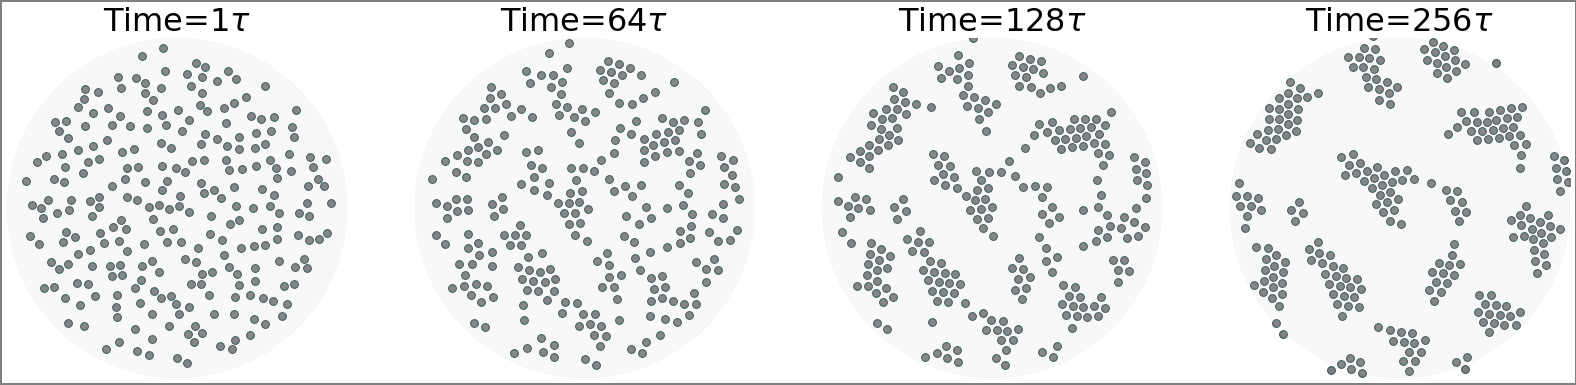

In [6]:
# plot the data at specific time instants
pystokes.utils.plotConfigs(t=[1, 64, 128, 256], ms=60, tau=(Tf/Npts)/(b/vs), filename='arrestedClusters')